In [1]:
import pandas as pd 
import numpy as np 
import geopandas as gpd 
import os 
import random
import scipy.stats as stats     
import time
import networkx as nx 
import matplotlib.pyplot as plt 
%matplotlib inline 

path = os.getcwd()
path
#rootpath = 'c:\\Users\\Gamelab\\Desktop\\RT\\Others\\Thesis\\Thesis_coding\\ABM\\Solar-Adoption-Agent-based-Model\\'
rootpath = '/Users/rtseinstein/Documents/GitHub/Solar-Adoption-Agent-based-Model/'
rootpath

'/Users/rtseinstein/Documents/GitHub/Solar-Adoption-Agent-based-Model/'

In [3]:
subset = gpd.read_file(rootpath+'data\\subset_households_5percent.shp')
subsetdf = subset[['case_id','bgid','household_','age','income','ami_catego','tract','elec_consu','BLOCKCE10','GEOID10']]

subsetdf['lon'] = subset.geometry.x
subsetdf['lat'] = subset.geometry.y
subsetdf.head()

<ipython-input-3-56d0fbb26afa>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subsetdf['lon'] = subset.geometry.x
<ipython-input-3-56d0fbb26afa>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subsetdf['lat'] = subset.geometry.y


,case_id,bgid,household_,age,income,ami_catego,tract,elec_consu,BLOCKCE10,GEOID10,lon,lat
0,49601,0136013,1person,65plus,less75k,1,013601,110.040484,3003,360010136013003,-73.761455,42.730810
1,43073,0146082,2person,65plus,75to100k,4,014608,124.086360,2000,360010146082000,-73.863765,42.689911
2,63832,0136022,2person,25to44,less75k,2,013602,101.029416,2016,360010136022016,-73.744885,42.688518
3,78663,0146144,1person,65plus,150kplus,4,014614,124.086360,4010,360010146144010,-73.892010,42.685147
4,59458,0135081,1person,25to44,75to100k,4,013508,124.086360,1000,360010135081000,-73.738781,42.811324


In [4]:
latmap ={}
lonmap = {}
blockmap = {}
ami_map = {}
elec_consumption_map = {}
tract_map = {}
bgid_map ={}
for _,row in subsetdf.iterrows():
    latmap[row['case_id']]=row['lat']
    lonmap[row['case_id']]= row['lon']
    blockmap[row['case_id']] = row['GEOID10']
    ami_map[row['case_id']]= row['ami_catego']
    elec_consumption_map[row['case_id']]= row['elec_consu']
    tract_map[row['case_id']]= row['tract']
    bgid_map[row['case_id']]= row['bgid']
    


In [5]:
initialized_subset = pd.read_csv(rootpath+'data\\subset_initialized.csv')
initialized_subset['lon'] = initialized_subset['CASE_ID'].map(lonmap)
initialized_subset['lat'] = initialized_subset['CASE_ID'].map(latmap)
initialized_subset['geoid'] = initialized_subset['CASE_ID'].map(blockmap)
initialized_subset['ami_categ'] = initialized_subset['CASE_ID'].map(ami_map)
initialized_subset['elec_consumption'] = initialized_subset['CASE_ID'].map(elec_consumption_map)
initialized_subset['tract'] = initialized_subset['CASE_ID'].map(tract_map)
initialized_subset['bgid'] = initialized_subset['CASE_ID'].map(bgid_map)

initialized_subset.head()

,CASE_ID,age,income,household_,attitude,subnorms,pbc,lon,lat,geoid,ami_categ,elec_consumption,tract,bgid
0,49601,65plus,less75k,0.0,0.2500,-0.50,-0.166667,-73.761455,42.730810,360010136013003,1,110.040484,013601,0136013
1,43073,65plus,75to100k,0.0,0.0625,0.00,-0.333333,-73.863765,42.689911,360010146082000,4,124.086360,014608,0146082
2,63832,25to44,less75k,0.0,0.8125,0.25,-0.333333,-73.744885,42.688518,360010136022016,2,101.029416,013602,0136022
3,78663,65plus,150kplus,0.0,0.6875,0.00,0.000000,-73.892010,42.685147,360010146144010,4,124.086360,014614,0146144
4,59458,25to44,75to100k,0.0,0.5000,0.50,-0.166667,-73.738781,42.811324,360010135081000,4,124.086360,013508,0135081


In [13]:
#export the intialized subset to csv for use in the network model 
initialized_subset.to_csv(rootpath+'data\\subset_initialized_latlonvalues.csv')

What i want is, a block_ids dictionary, that holds, for each block what are the case_ids. Then, from each block, I will generate nodes and create random edges between them each time-step. Instead of reading all the nodes again and create edges fresh from the start, I can at every timestep:
- 1. <within the same block> for each case_id as source, pick another random case_id as destination. so the assumption is that, every time-step every person will interact once with another person. Possible that one person is interacted with many times. 
- 2. Remove all the edges and re-assign edges at the start of the time-step. 


In [2]:
def add_and_remove_edges(G, p_new_connection, p_remove_connection):    
    '''    
    for each node,    
      add a new connection to random other node, with prob p_new_connection,    
      remove a connection, with prob p_remove_connection    

    operates on G in-place    
    '''                
    new_edges = []    
    rem_edges = [] 
    for node in G.nodes():    
        # find the other nodes this one is connected to    
        connected = [to for (fr, to) in G.edges(node)]    
        # and find the remainder of nodes, which are candidates for new edges   
        unconnected = [n for n in G.nodes() if not n in connected]    

        # probabilistically add a random edge    
        if len(unconnected): # only try if new edge is possible    
            if random.random() < p_new_connection:    
                new = random.choice(unconnected)    
                G.add_edge(node, new)    
                #print("\tnew edge:\t {} -- {}".format(node, new)    
                new_edges.append( (node, new) )    
                # book-keeping, in case both add and remove done in same cycle  
                unconnected.remove(new)    
                connected.append(new)    

        # probabilistically remove a random edge    
        if len(connected): # only try if an edge exists to remove    
            if random.random() < p_remove_connection:    
                remove = random.choice(connected)    
                G.remove_edge(node, remove)    
                #print "\tedge removed:\t {} -- {}".format(node, remove)    
                rem_edges.append( (node, remove) )    
                # book-keeping, in case lists are important later?    
                connected.remove(remove)    
                unconnected.append(remove)    
    return rem_edges, new_edges

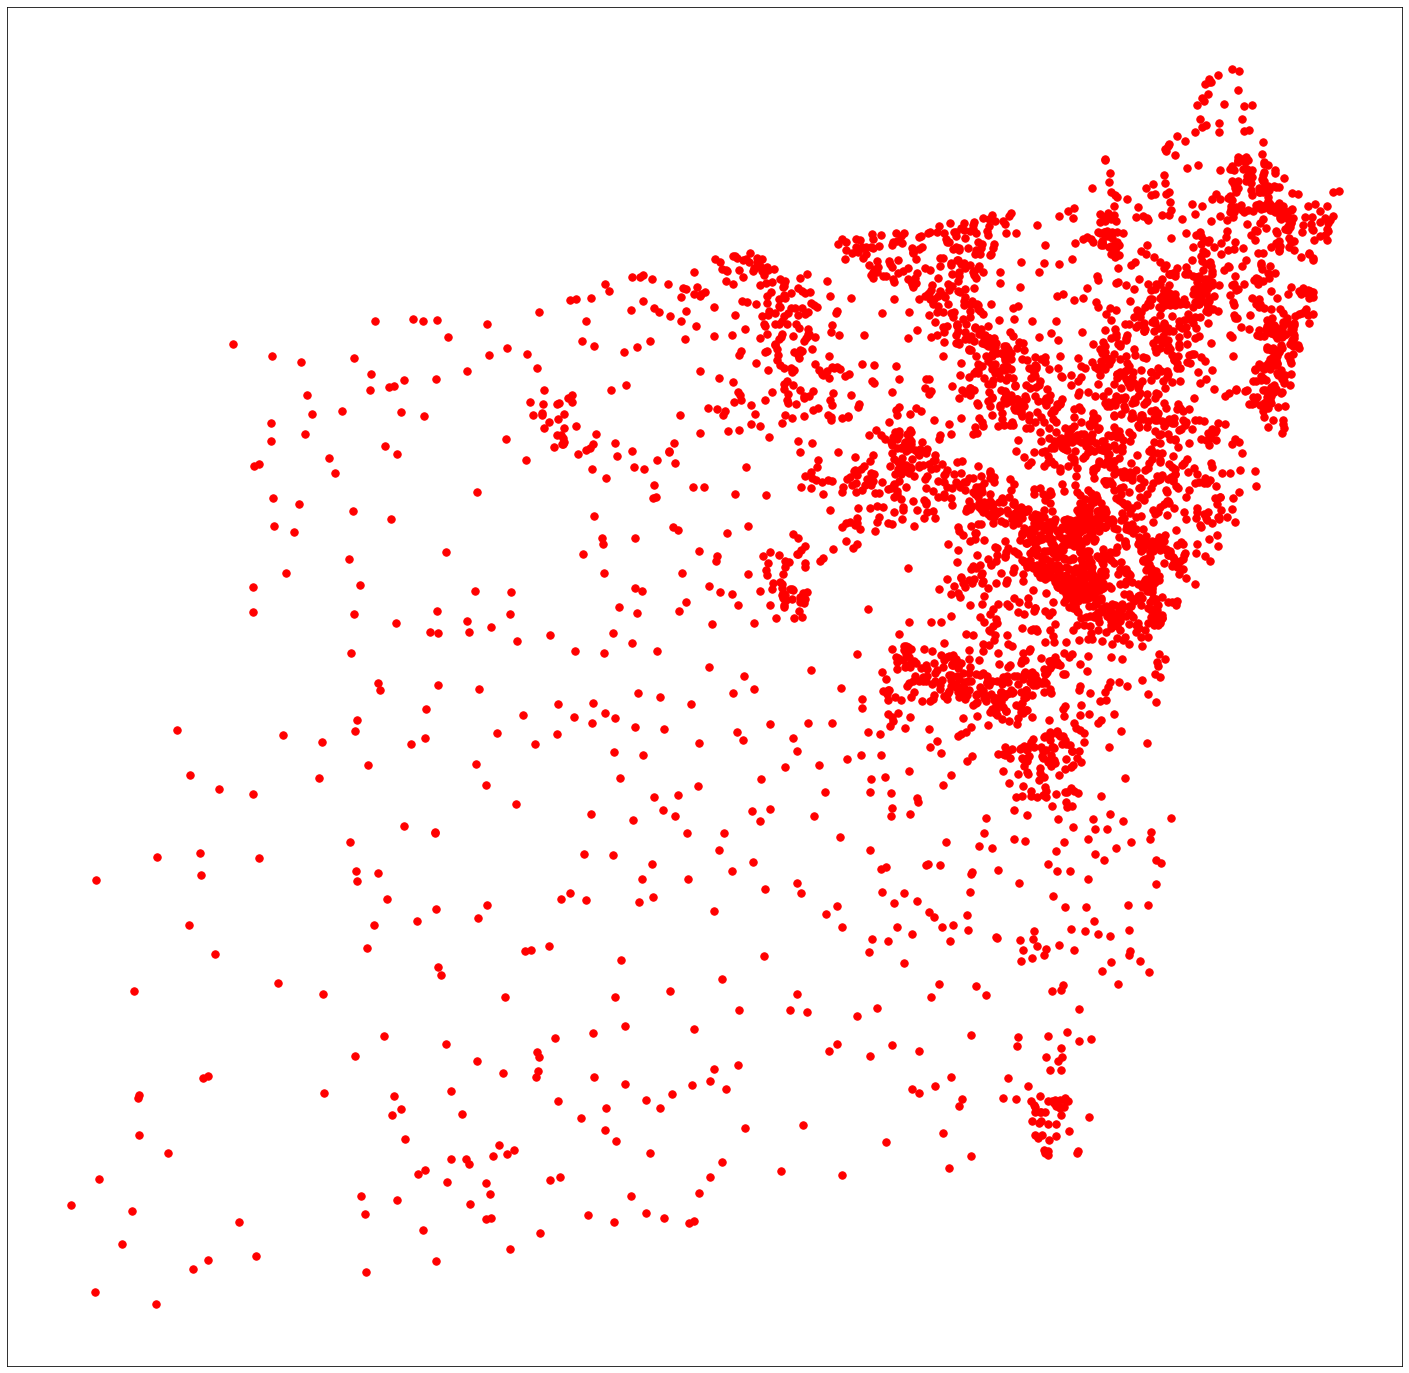

In [3]:
df = pd.read_csv(rootpath+'data\\subset_initialized_latlonvalues.csv')
df = df.drop(columns='Unnamed: 0')
households_in_block = {}
household_ids_in_block = {}
graph_dict = {}                                                         # holds all the graphs indexed by blockid [geoid]
main_graph = nx.Graph()
#now i need to get number of geoids unique 
for block in df['geoid'].unique():  
    G=nx.Graph()
    households_in_block[block] = df[df['geoid']==block]                 # contains all the information about the households 
    household_ids_in_block[block] =  df[df['geoid']==block]['CASE_ID'].values  
                                                                        # contains only their ID
                                                                        # you only need id to initialize a node
    tempdf = households_in_block[block]
    for household in household_ids_in_block[block]:
        lon = tempdf.loc[tempdf['CASE_ID']==household,'lon'].values[0]
        lat = tempdf.loc[tempdf['CASE_ID']==household,'lat'].values[0]        
        
        G.add_node(household, pos=(lon,lat))
        main_graph.add_node(household, pos=(lon,lat))

    ## add G to the dictionary
    graph_dict[block] = G

## draw the main graph 
fig,ax = plt.subplots(figsize=(25,25))
nx.draw_networkx(main_graph,nx.get_node_attributes(main_graph, 'pos'),ax=ax,node_size=55,with_labels=False,node_color='red')

In [4]:
# now you have a main_graph that contains all the nodes, a dictionary, that contains the nodes of all households blockwise
# for every timestep, you need to create a copy of main_graph that has random edges drawn between its block-mates 
p_new_connection=0.85
p_remove_connection= 0.85
main_graph_dict = {}  #to store the main graph at each step for quick plotting 

for i in range(5):
    main_graph_copy = main_graph
    for block in list(graph_dict.keys()):
        tempG = graph_dict[block]  #gets the graph of that block 
                                   #draw random edges between pairs of them
        rem_edges, new_edges = add_and_remove_edges(tempG, p_new_connection, p_remove_connection)
        tempG.remove_edges_from(rem_edges)
        tempG.add_edges_from(new_edges)
        main_graph_copy= nx.compose(main_graph_copy,tempG)

    main_graph_dict[i] = main_graph_copy


        

In [34]:
payback_period = [0,3,5,6,7.5,8,10,15,20,25,30]
tolerating_perc = [100,95,78,50,40,35,25,10,5,1,0] 

rootpath = 'c:\\Users\\Gamelab\\Desktop\\RT\\Others\\Thesis\\Thesis_coding\\ABM\\' 
df = pd.read_csv(rootpath+'data\\subset_initialized_latlonvalues.csv')
df = df.drop(columns='Unnamed: 0') 
df['pbc'] = df['pbc'].astype('float')

dflength = len(df)
caseid = '49601'
if caseid in list(df['pbc'].sort_values(ascending=True).head(int(0.01*dflength))):
    print('caseid lies within 100 percentage of the pbc')



In [52]:
pbc_dict = {}
for _,row in df.iterrows():
    pbc_dict[row['CASE_ID']] = [row['pbc']]

values = list(df['pbc'])
percentages = []
min_value = min(values)
max_value = max(values)

for caseid in list(pbc_dict.keys()):
  fraction = ((pbc_dict[caseid][0] - min_value) / (max_value - min_value))*100
  pbc_dict[caseid].append(fraction)
  if 0<= fraction <1:
      pbc_dict[caseid].append(0)
  if 1<= fraction <5:
      pbc_dict[caseid].append(3)
  if 5<= fraction <10: 
      pbc_dict[caseid].append(5)
  if 10<= fraction <25: 
      pbc_dict[caseid].append(6)
  if 25<= fraction <35: 
      pbc_dict[caseid].append(7.5)
  if 35<= fraction <40: 
      pbc_dict[caseid].append(8)
  if 40<= fraction <50: 
      pbc_dict[caseid].append(10)
  if 50<= fraction <78: 
      pbc_dict[caseid].append(15)
  if 78<= fraction <95: 
      pbc_dict[caseid].append(20)
  if 95<= fraction <100: 
      pbc_dict[caseid].append(25)
  if fraction== 100: 
      pbc_dict[caseid].append(30)

pbc_dict
    




0.0, 15],
 79763: [-0.5, 25.0, 7.5],
 11994: [-0.3333333333333333, 33.333333333333336, 7.5],
 46653: [-0.1666666666666666, 41.66666666666667, 10],
 33426: [-0.5, 25.0, 7.5],
 47800: [0.0, 50.0, 15],
 47767: [-0.1666666666666666, 41.66666666666667, 10],
 49965: [-0.3333333333333333, 33.333333333333336, 7.5],
 36044: [-0.3333333333333333, 33.333333333333336, 7.5],
 62980: [0.1666666666666666, 58.33333333333333, 15],
 55657: [-0.5, 25.0, 7.5],
 21091: [-0.5, 25.0, 7.5],
 49847: [-0.1666666666666666, 41.66666666666667, 10],
 55016: [-0.3333333333333333, 33.333333333333336, 7.5],
 35776: [0.3333333333333333, 66.66666666666666, 15],
 34416: [-0.3333333333333333, 33.333333333333336, 7.5],
 46141: [-0.5, 25.0, 7.5],
 62042: [-0.3333333333333333, 33.333333333333336, 7.5],
 62864: [-0.6666666666666666, 16.666666666666668, 6],
 71259: [-0.5, 25.0, 7.5],
 3453: [0.0, 50.0, 15],
 7792: [-0.1666666666666666, 41.66666666666667, 10],
 49855: [-0.1666666666666666, 41.66666666666667, 10],
 35161: [-0.33

(array([ 267., 2438., 1225.,   14.,    6.]),
 array([ 0.,  6., 12., 18., 24., 30.]),
 <BarContainer object of 5 artists>)

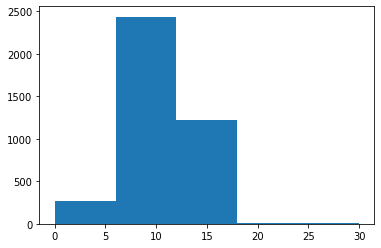

In [66]:
a = []
for i in list(pbc_dict.values()):
    a.append(i[2])

plt.hist(a, bins=5)

### 16th June 2021 




In [33]:
main = gpd.read_file(rootpath+'data\\households_main\\households_main.shp')
#if less than 1person or 2person: householdsize = 0
#if 3 or more, householdsize = 1 

householdsize_map = {'1person':0,'2person':0,'3person':1,'4person':1,'5person':1,'6person':1,'7person':1}
main['hhsize']= main['household_'].map(householdsize_map)

main= main.drop(columns=['household_'])
main = main.rename(columns={'hhsize':'household_'})

main.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 80301 entries, 0 to 80300
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   rand_point  80301 non-null  float64 
 1   case_id     80301 non-null  int64   
 2   bgid        80301 non-null  object  
 3   age         80301 non-null  object  
 4   income      80301 non-null  object  
 5   sample_inc  80301 non-null  float64 
 6   ami_catego  80301 non-null  int64   
 7   tract       80301 non-null  object  
 8   elec_consu  80301 non-null  float64 
 9   TRACTCE10   80281 non-null  object  
 10  BLOCKCE10   80281 non-null  object  
 11  GEOID10     80281 non-null  object  
 12  geometry    80301 non-null  geometry
 13  household_  80301 non-null  int64   
dtypes: float64(3), geometry(1), int64(3), object(7)
memory usage: 8.6+ MB


In [35]:
main['age']=main['age'].astype('string')
main['income']=main['income'].astype('string')

# exported already
#main.to_csv(rootpath+'data\\households_main\\households_main.csv')

In [43]:
import pandas as pd 
import os 
import networkx as nx 
import numpy as np
import matplotlib.pyplot as plt 
plt.close('all')
from matplotlib.animation import FuncAnimation


rootpath = 'c:\\Users\\Gamelab\\Desktop\\RT\\Others\\Thesis\\Thesis_coding\\ABM\\Solar-Adoption-Agent-Based-Model\\' 
interactions = pd.read_csv(rootpath+'experiment\\interactions_mainsubset_36runs.csv')
interactions = interactions.drop(columns='Unnamed: 0')
interactions['first_agent'] = interactions['first_agent'].astype('string') 
interactions['second_agent'] = interactions['second_agent'].astype('string') 

#now import the latlon values file 
subset = pd.read_csv(rootpath+'data\\households_subset\\subset_initialized_latlonvalues.csv')
subset = subset.drop(columns='Unnamed: 0')
# create map of values 
subset['CASE_ID']=subset['CASE_ID'].astype(int)
subset = subset.set_index('CASE_ID')
subset['lat']= subset['lat'].astype(float)
subset['lat']= subset['lat'].astype(float)

latmap = subset['lat'].to_dict()
lonmap = subset['lon'].to_dict()
counter=0
graph_dict =  {}
for step in list(interactions['timestep'].unique()):
    #get a dataframe of the timestep
    timestepdf = interactions.loc[interactions['timestep']==step]
    G=nx.MultiGraph()
    for _,row in timestepdf.iterrows():
        # add subgraphs which will then be added to the main graph_dict
        first_agent = int(row['first_agent'])
        try:
            G.add_node(first_agent, pos=(latmap[first_agent],lonmap[first_agent])) 
        except:
            print('first agent exception')
            counter+=1
            G.add_node(first_agent)
        second_agent = int(row['second_agent'])
        try:
            G.add_node(second_agent, pos=(latmap[second_agent],lonmap[second_agent]))
        except:
            print('second agent exception')
            counter+=1
            G.add_node(second_agent)
        G.add_edge(first_agent,second_agent)

    graph_dict[step]=G 

print(counter, 'exceptions were made out of', len(interactions))
graph_dict

0 exceptions were made out of 85861


{0: <networkx.classes.multigraph.MultiGraph at 0x17822b8d0b8>,
 1: <networkx.classes.multigraph.MultiGraph at 0x17822b8d710>,
 2: <networkx.classes.multigraph.MultiGraph at 0x17822b8d208>,
 3: <networkx.classes.multigraph.MultiGraph at 0x1783b17ee48>,
 4: <networkx.classes.multigraph.MultiGraph at 0x1783b17ef60>,
 5: <networkx.classes.multigraph.MultiGraph at 0x1783b17ee10>,
 6: <networkx.classes.multigraph.MultiGraph at 0x17822b8def0>,
 7: <networkx.classes.multigraph.MultiGraph at 0x1783b17ee80>,
 8: <networkx.classes.multigraph.MultiGraph at 0x1783b17ef28>,
 9: <networkx.classes.multigraph.MultiGraph at 0x1783b17ed30>,
 10: <networkx.classes.multigraph.MultiGraph at 0x1783b17ecc0>,
 11: <networkx.classes.multigraph.MultiGraph at 0x1783b17ecf8>,
 12: <networkx.classes.multigraph.MultiGraph at 0x1783b17ec50>,
 13: <networkx.classes.multigraph.MultiGraph at 0x1783b17ebe0>,
 14: <networkx.classes.multigraph.MultiGraph at 0x1783b17ec18>,
 15: <networkx.classes.multigraph.MultiGraph at 0x

In [37]:
import pandas as pd 
import os 
import networkx as nx 
import numpy as np
import matplotlib.pyplot as plt 
plt.close('all')
from matplotlib.animation import FuncAnimation


def animate_nodes(G, pos=None, *args, **kwargs):

    if pos is None:
        pos = nx.spring_layout(G) 
        
    nodes = nx.draw_networkx_nodes(G, node_color="#1f78b4")
    edges = nx.draw_networkx_edges(G)
    plt.axis('off')

    def update(ii):
        return nodes


    fig = plt.gcf()
    animation = FuncAnimation(fig, update, interval = 50, frames=1, blit=True)
    return animation 

for step in list(graph_dict.keys()):
    G = graph_dict[step]
    timesteps = len(interactions['timestep'].unique())
    total_nodes = len(list(G.nodes))
    G = nx.complete_graph(total_nodes)
    
    node_colors = np.random.randint(0, 100, size=(timesteps, total_nodes))
    animation = animate_nodes(G)


    

KeyboardInterrupt: 

## Plotly Interaction Code

In [98]:
import plotly.graph_objects as go
import geopandas as gpd
import contextily as cx 
rootpath = 'c:\\Users\\Gamelab\\Desktop\\RT\\Others\\Thesis\\Thesis_coding\\ABM\\Solar-Adoption-Agent-Based-Model\\' 

#albany = gpd.read_file(rootpath+'data\\shapefiles\\albany_census_blocks.shp')
#ax = albany.to_crs('EPSG:3857').plot()
#cx.add_basemap(ax)
from ipywidgets import interact
import contextily as cx 
fig= go.FigureWidget()

fig.update_layout(
    autosize=False,
    width=500,
    height=1500) 
fig.layout.title = 'Interacts over timestep'


@interact(step=(0,36,1))
def update(step=0):
    with fig.batch_update():
        #albany.to_crs('EPSG:4326').plot(facecolor='blue',alpha=0.4)
        nx.draw(graph_dict[step], nx.get_node_attributes(graph_dict[step], 'pos'), node_size=2)



interactive(children=(IntSlider(value=0, description='step', max=36), Output()), _dom_classes=('widget-interac…

## Creating Dictionary to update values in parallel program

22nd June 2021

The structure is:

{ agentid : {timestep1: [list of value changes], 
             timestep2: [list of value changes]} ,

agentid2  : {timestep1: [list of value changes], 
             timestep2: [list of value changes]}     
}

In the code:
- Create attitude, pbc, social norms dictionaries at the a) initialisation, b) in generate model, for every agent= {} c) at every timestep, add a [] for every agent and timestep 

-  the key task here is to connect one step to another. to take the last value of the previous timestep as the first value of this timestep. 
    - so we need something like: at every ra_implementation, initial_value = list[-1]
    - add the new value to the list. 

    - 

In [6]:
attitudes= {1234 : {1: [0.1 , 0.2 , 0.3, 0.4], 
		                2 : [0.4, 0.45, 0.5],
		                3: [0.5, 0.55, 0.57]}
                        ,
	   5678 : {1: [0.1 , 0.2 , 0.3, 0.4], 
		            2 : [0.4, 0.45, 0.5],
		            3: [0.5, 0.55, 0.57] } 
            } 

3